# Loglikelihood Functions (Flow data)
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

For a list of time samples, a set of N distributions for each time point is generated from the model using stochastic simulations, from either the same or different initial conditions. Gaussian noise is then added to all the samples to create an artificial data set. Then, we run the stochastic states likelihood computations in bioscrape inference package. 

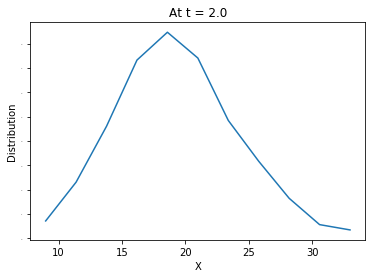

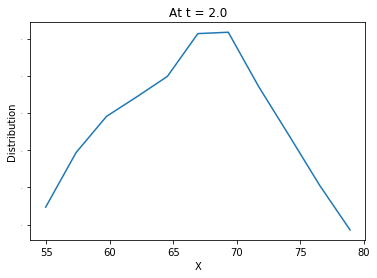

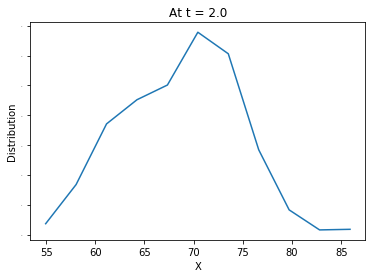

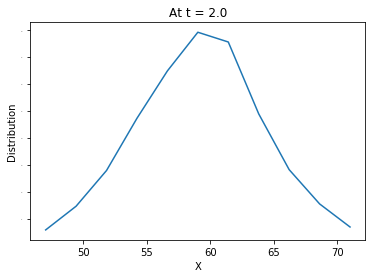

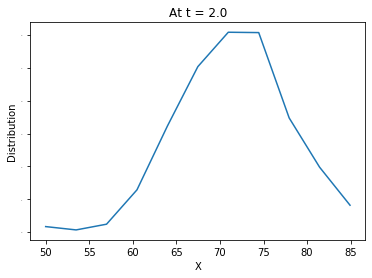

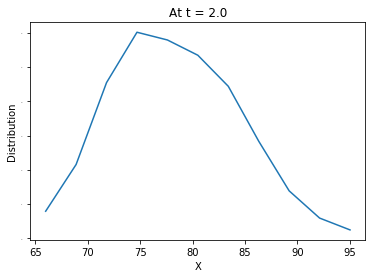

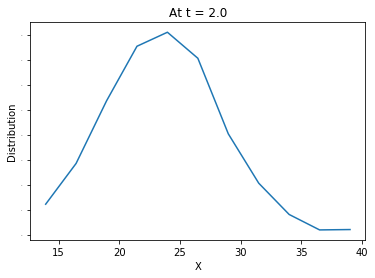

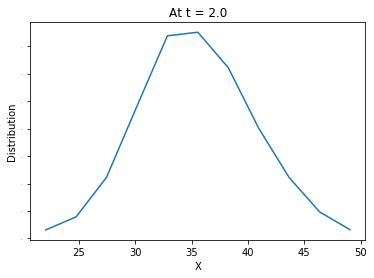

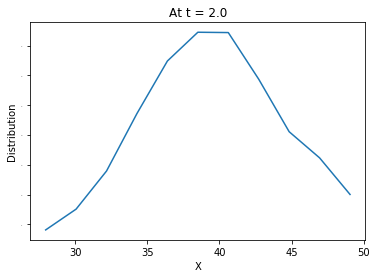

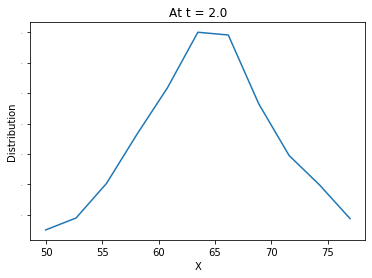

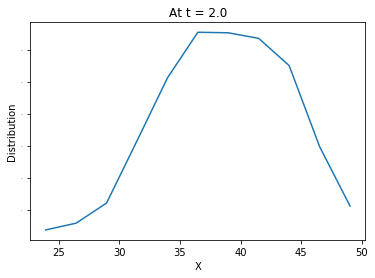

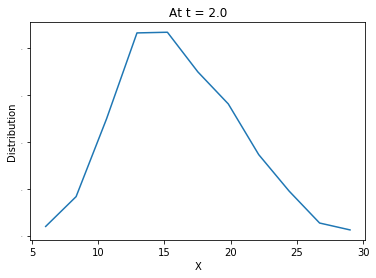

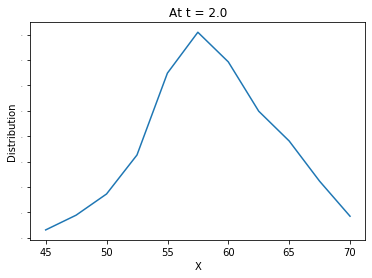

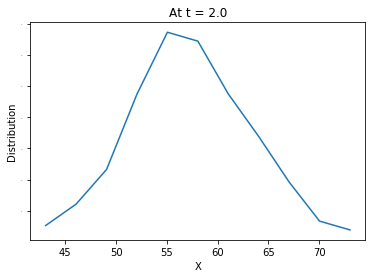

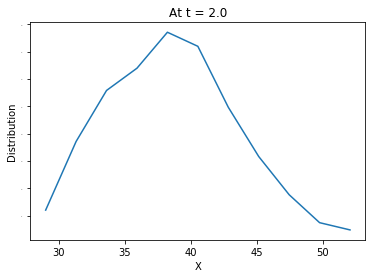

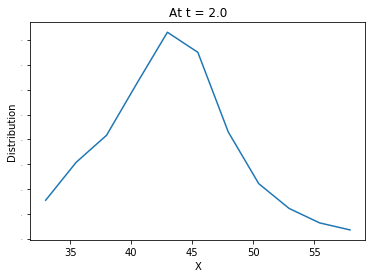

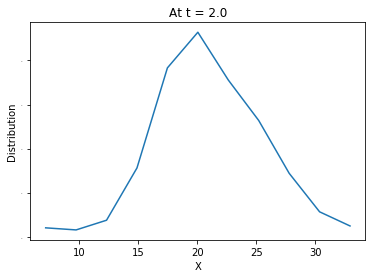

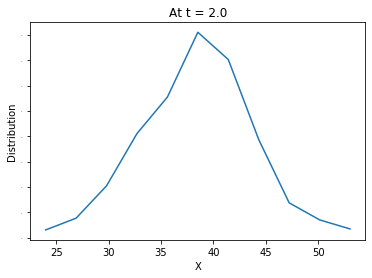

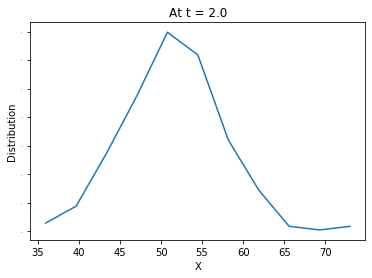

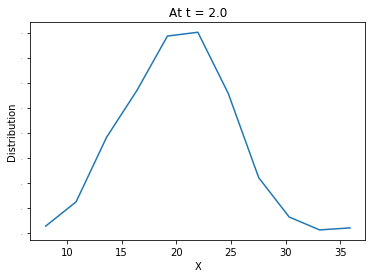

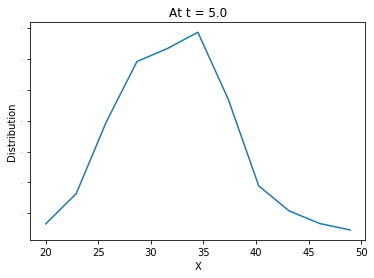

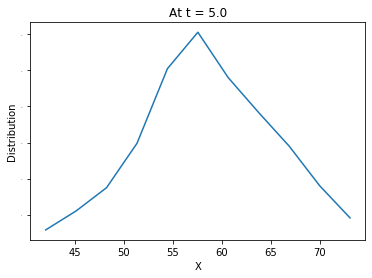

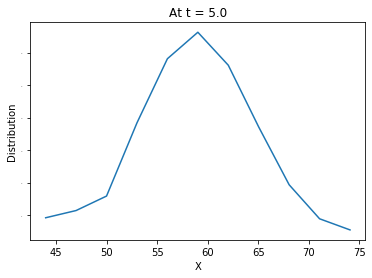

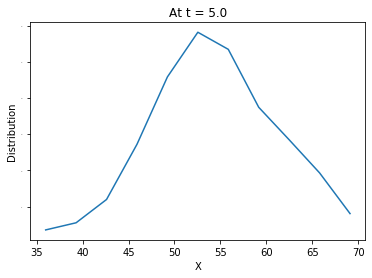

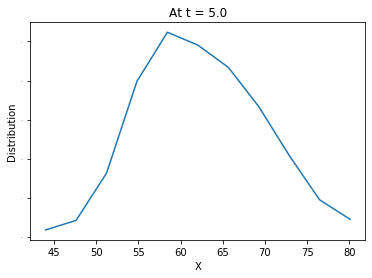

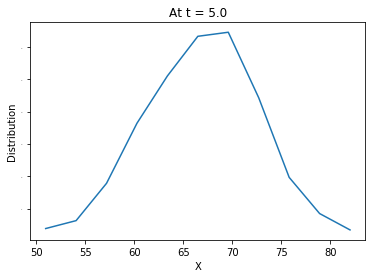

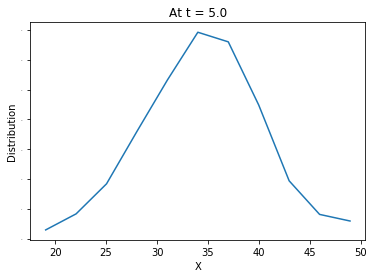

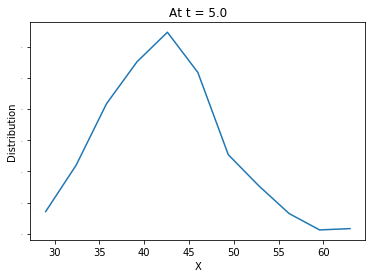

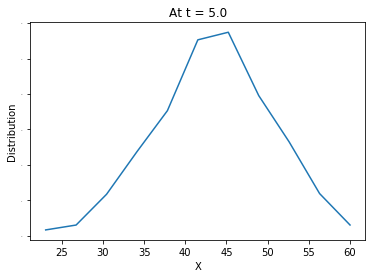

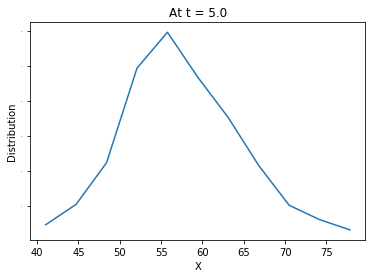

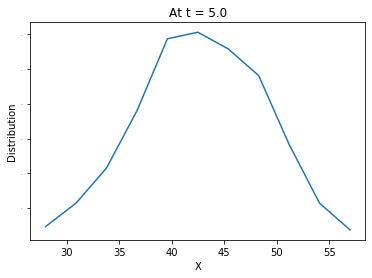

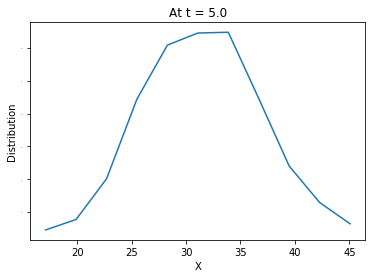

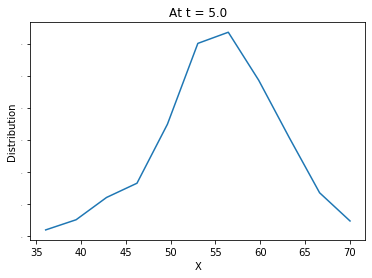

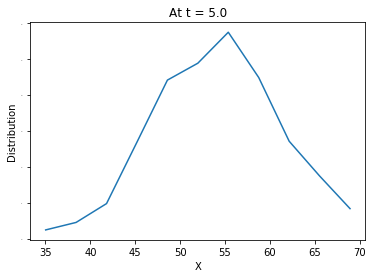

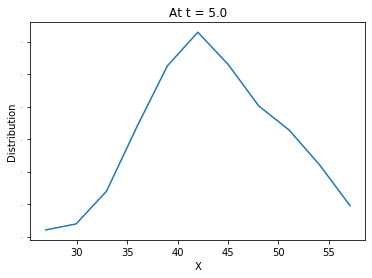

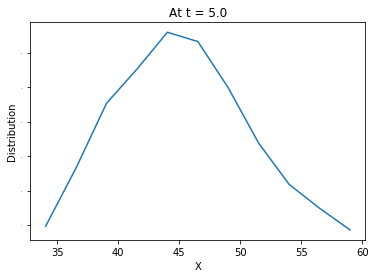

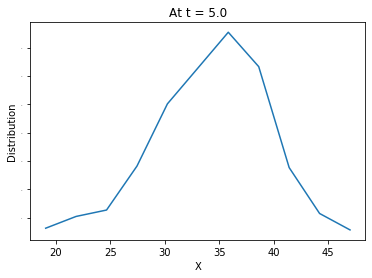

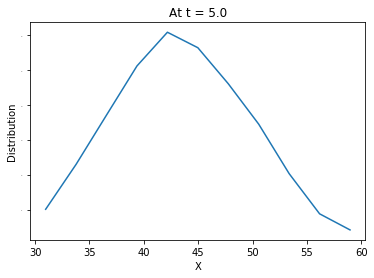

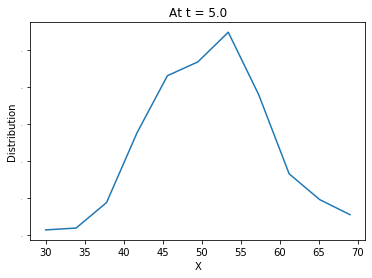

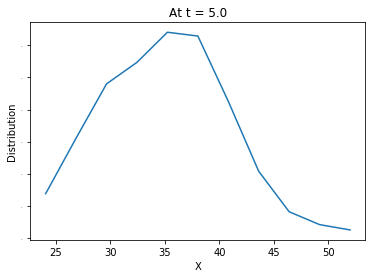

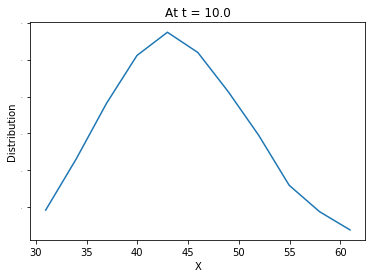

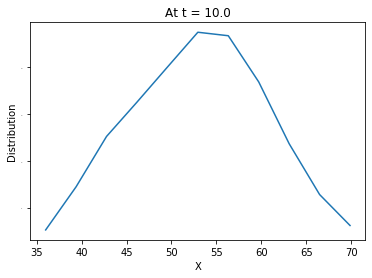

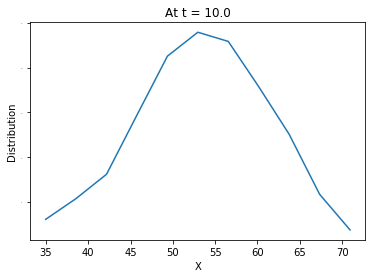

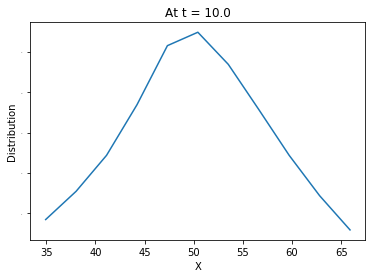

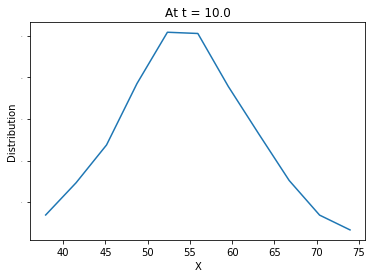

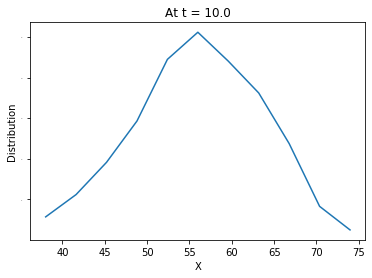

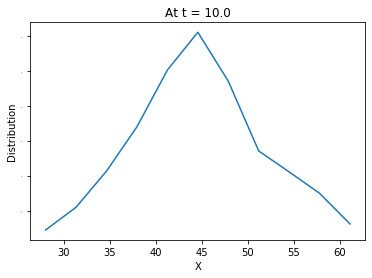

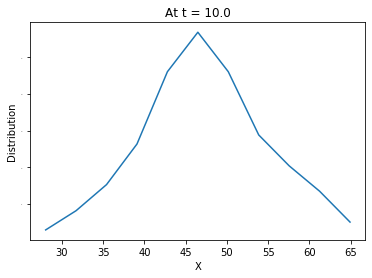

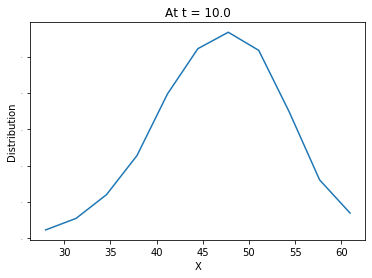

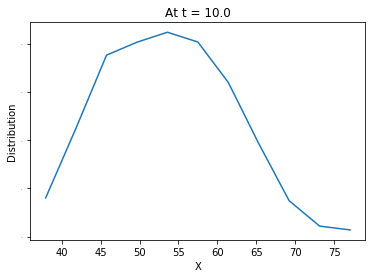

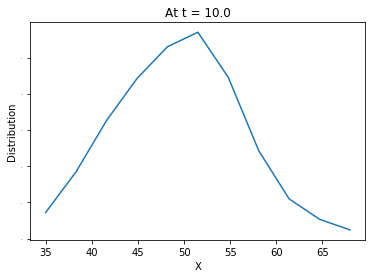

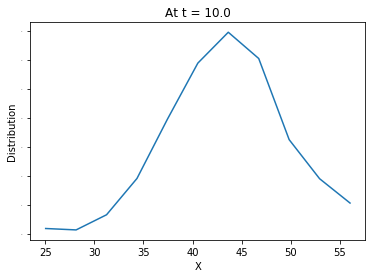

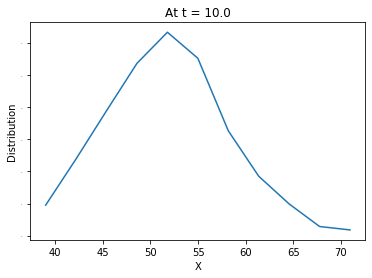

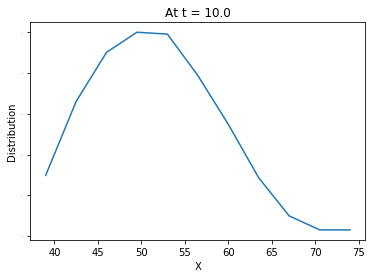

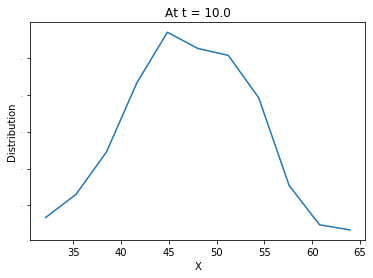

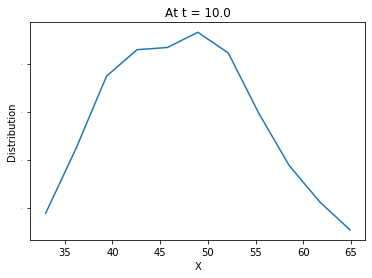

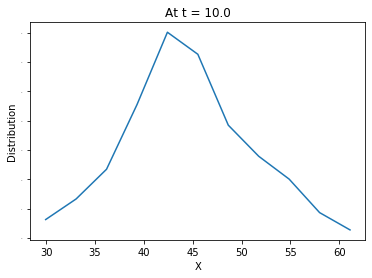

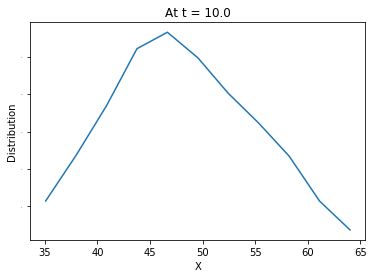

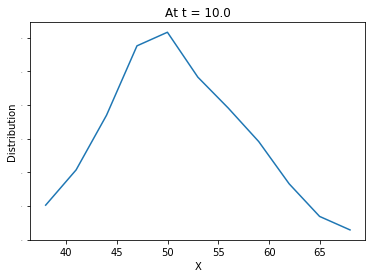

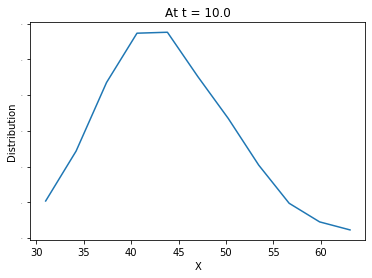

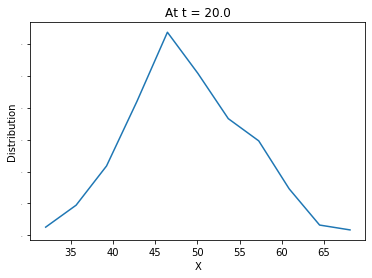

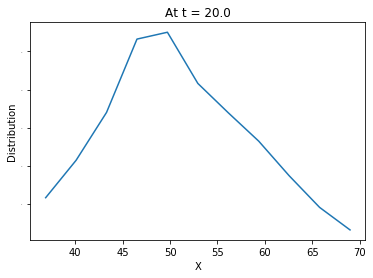

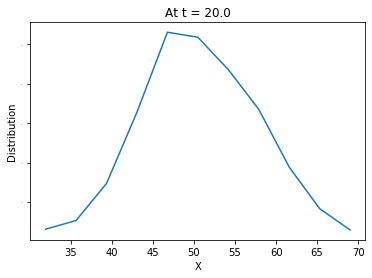

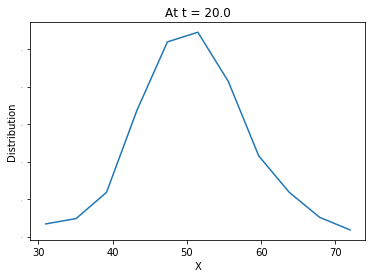

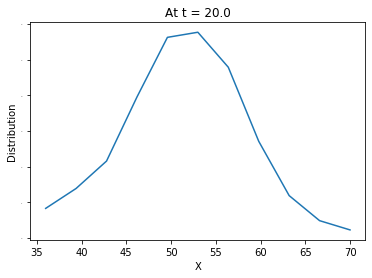

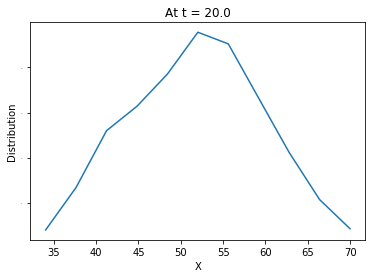

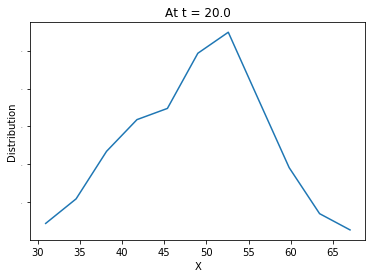

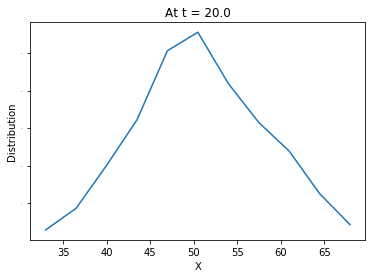

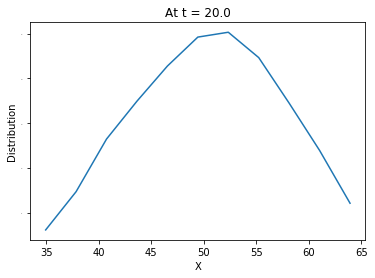

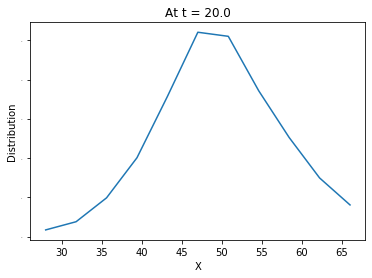

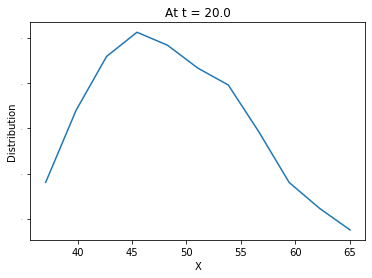

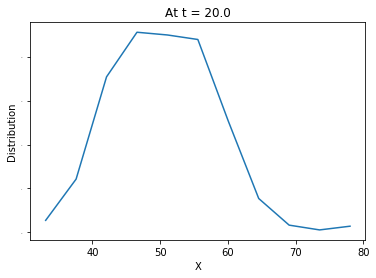

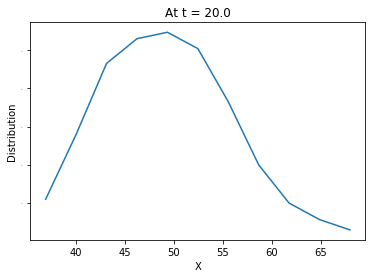

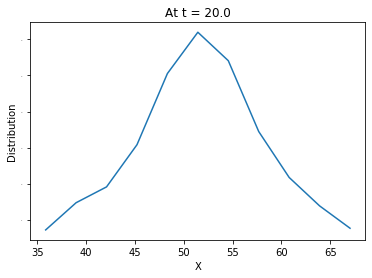

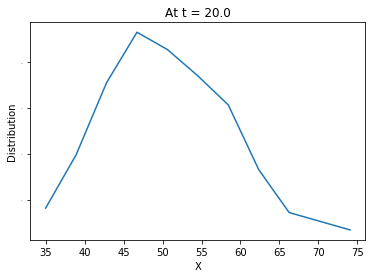

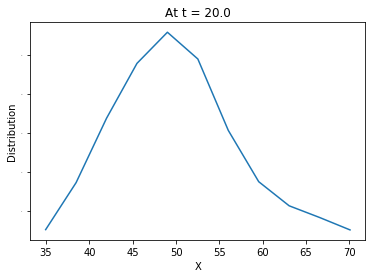

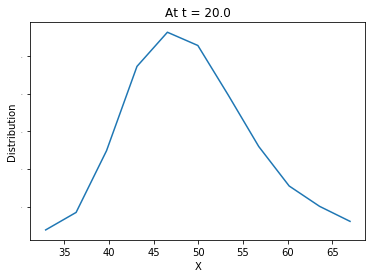

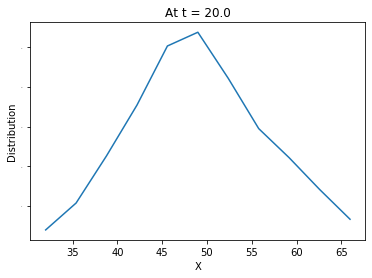

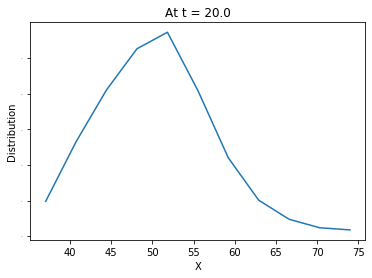

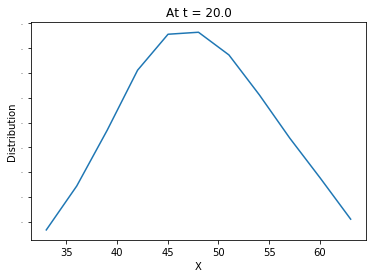

In [6]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import scipy.stats as stats
import numpy as np
import pylab as plt
#Create a Model
species = ["X"]
reactions = [(["X"], [], "massaction", {"k":"d1"}), ([], ["X"], "massaction", {"k":"k1"})]
k1 = 10.0
d1 = .2
params = [("k1", k1), ("d1", d1)]
initial_condition = {"X":0}
M = Model(species = species, reactions = reactions, parameters = params, initial_condition_dict = initial_condition)
M.py_initialize()

N = 20 #Number of flow distributions taken
time_samples = [2.0,5.0,10.0,20.0] #time samples at which data is taken
nS = len(time_samples)
noise_std = 0.05 #Standar deviation of the guassian noise added onto the measurements

#Generate Distributions
R = [] #Results as Pandas Dataframes
Data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?
N_simulations = 100
meas = 1 # Number of measurements 
Data = np.zeros( (nS,N,N_simulations,meas))
X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {"X": np.random.randint(0, 100)}
        X0_list.append(initial_condition)
for nS_i in range(nS):
    t = time_samples[nS_i]
    for n in range(N):
        initial_condition = X0_list[n]
        M.set_species(initial_condition)
        for i in range(N_simulations):
            r = py_simulate_model(np.array([0,t]), Model = M, stochastic = True)
            R.append(r["X"][1])
            noisy_data = r["X"][1] + np.random.normal(loc = 0, scale = noise_std, size = 1)
            Data[nS_i,n,i] = noisy_data
        


#Plot Results
plt.figure()
# Data = np.array(Data)
# Data = np.reshape(Data, ( np.shape(Data)+ (meas,))) # To make sure Data has shape - nS X N X M (where M = len(measured_species))
for i in range(nS):
    for j in range(N):
        n_bins = int(N_simulations/10)  
        density = stats.gaussian_kde(Data[i,j,:,0])
        n, x, _ = plt.hist(Data[i,j,:,0], bins = n_bins, histtype = u'step', density = True)  
        plt.close()
        plt.plot(x, density(x))
        plt.title('At t = {0}'.format(time_samples[i]))
        _ = plt.xlabel("X")
        _ = plt.ylabel("Distribution")
        plt.yticks(fontsize = 0)
        plt.show()

In [8]:
np.shape(Data)
# (number_of_time_points, samples_of_data_taken, length_of_distribution_array, number_of_measure_species )

(4, 20, 100, 1)

## Data Objects and Loglikelihood Objects for Trajectories
Different kinds of data must be stored in specific kinds of data objects. In turn, each Log-likelihood object is designed to accept a single kind of data object.

Refer to time-series data objects notebook for more information on DeterministicLikelihood and StochasticTrajectoriesLikelihood.

### StochasticStates Constructor
*  Time samples: The list of time points at which flow data is taken. Simulations will use the same time samples to generate distributions.
*  Data: an nS X N x L X M array. nS : Length of time_samples array, i.e. the number of different time samples at which data is taken. N: number of samples at each time point. L: The length of flow data (that generates the distribution). M: number of species measured
* measured_species: list of M species names corresponding to model species and measurements.
* N: Number of samples.

### StochasticStatesLikelihood Constructor
* model: A Bioscrape Model
* data: StochasticStates Data Object. If not passed in, can be added via .set_data(StochasticStates) method.
#### Optional:
 * N_simulations: Number of simulations per sample. Defaults to 1.
 * norm_order: What L-norm to use. Defaults to 1.
 * moment_order: What order of moments to use for cost computation. (moment_order = 2 computes the mean and the 2nd order central moment. moment_order = 1 only computes the mean).
 * moment_weights : A list of weights that has the same length as the moment_order. Weights are used for cost computation as follows : W_1 * mean + W_2 * 2nd_moment ...and so on. 
 * ModelCSimInterface. Generated from Model otherwise.
 * Simulator: How to simulate the model. Defaults to SSASimulator or DelaySSASimulator otherwise.
 
 #### Important : Either norm_order or moment_order option should be used for cost computations. Setting both will raise an error. 
 

In [9]:
#Create LogLikelihoodFunction
from bioscrape.inference import StochasticStatesLikelihood as SSLL
from bioscrape.inference import FlowData


# Create a Data Objects
DataFlow = FlowData(np.array(time_samples), Data, ["X"], N)

#Ceate Likelihodo objects:
N_simulations = 100 #Number of simulations per sample to compare to
# norm_order = 1 #(integer) Which norm to use: 1-Norm, 2-norm, etc.
moment_order = 2 # (integer) Upto what norm do you want to include for cost computation. 

#If there are multiple initial conditions in a data-set, should correspond to multiple initial conditions for inference.
#Note len(X0_list) must be equal to the number of trajectories N
if MultipleInitialConditions:    
    # Either use norms or moments for cost computation
#     LL_stoch = SSLL(model = M, init_state = X0_list, data = DataFlow, N_simulations = N_simulations, norm_order = norm_order)
    LL_flow = SSLL(model = M, init_state = X0_list, data = DataFlow, N_simulations = N_simulations, moment_order = moment_order)

    

#Multiple samples with a single initial only require a single initial condition.
else:
    # Either use norms or moments for cost computation
#     LL_stoch = SSLL(model = M, init_state = X0_list, data = DataFlow, N_simulations = N_simulations, norm_order = norm_order)
    LL_flow = SSLL(model = M, init_state = initial_condition, data = DataFlow, N_simulations = N_simulations, moment_order = moment_order)
print("LL_flow.N_simulations", LL_flow.py_get_N_simulations())

LL_flow.N_simulations 100


di= 0...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 1...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 2...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 3...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 4...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 5...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 6...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 7...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 8...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 9...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 10...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 11...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 12...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 13...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 14...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


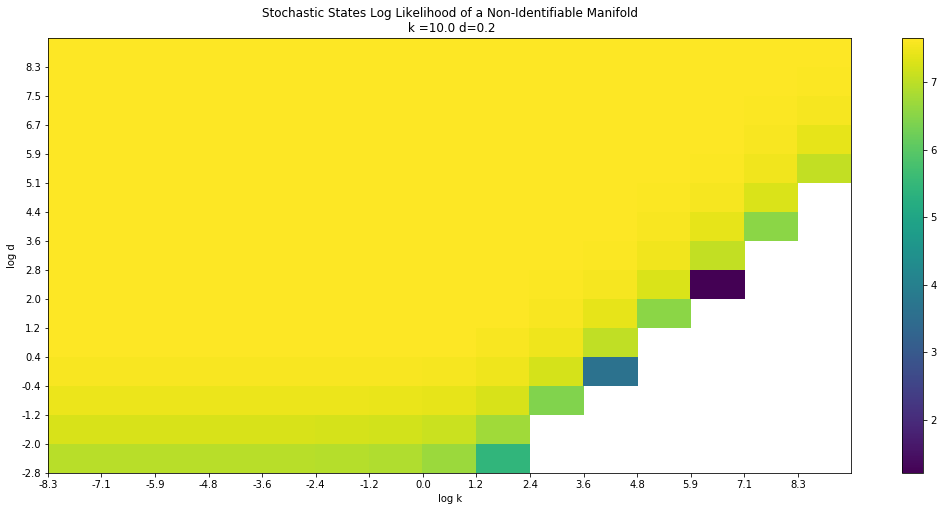

In [12]:
npoints = 15
d_list = np.logspace(-4, 12, base = 2, num = npoints)
k_list = np.logspace(-12, 12, base = 2, num = npoints)
HM_flow = np.zeros((len(d_list), len(k_list)))

for di in range(len(d_list)):
    print("di=", di, end = "...ki =")
    for ki in range(len(k_list)):
        print(ki, end = " ")
        LL_flow.set_init_params({"d1":d_list[di], "k1":k_list[ki]})
        
        vs = LL_flow.py_log_likelihood()
        
        HM_flow[di, ki] = -vs

plt.figure(figsize = (18, 8))
plt.title("Stochastic States Log Likelihood of a Non-Identifiable Manifold\n k ="+str(k1)+" d="+str(d1))
plt.xlabel("log k")
plt.xticks(range(npoints), [round(np.log(k), 1) for k in k_list])
plt.ylabel("log d")
plt.yticks(range(npoints), [round(np.log(d), 1) for d in d_list])
cb = plt.pcolor(np.log(HM_flow))
_ = plt.colorbar(cb)


In [7]:
# LL_flow.py_get_moment_weights()
LL_flow.py_log_likelihood()

-0.0